In [16]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'

# Matrix factorization recommenders

### Objectives

* Review: describe recommender systems
  * how is their goal different than supervised learning?
  * describe strategies
    * supervised learning
    * content-based similarity
    * user-based similarity
    * item-based similarity
* Review: topic modeling using matrix decomp
  * NMF
  * SVD
* Describe how matrix decomp can be used to predict ratings
* Review: gradient descent; derivatives
* Bonus: implement gradient descent for review prediction

### Recommender system review

* The goal is to predict a set of items that are "relevant".
 * "Relevance" can mean anything; this task is very broad.
* A common definition of "relevant": an unrated item that a user would rate highly.
 * "You'll like this."
* Thus a common strategy for recommender systems is to predict ratings using a scheme with low error on highly rated items, and then return a bundle of the top predictions.
* Often the featurization of our items is relatively sparse; we can often use other people's ratings as features ("collaborative filtering").
* Given that we only care about getting relevant items, we can often just recommend similar items (or items like by similar users).

## Matrix factorization for genre discovery review

In [17]:
# grab some moview review data; conver into a utility matrix
df = pd.read_table("data/u.data", names=["user_id", "movie_id", "rating", "timestamp"])
utility = pd.pivot_table( df, values="rating", index="user_id", columns="movie_id")

items_df = pd.read_csv("data/u.item", sep="|", header=None, encoding="latin1", index_col=0)
movie_titles = items_df[1]

In [18]:
# popular movies and prolific raters
movie_ids = [50,  100,  181,  258,  174,  127,  286, 1, 98]
user_ids = [450, 655,  13, 416, 276, 303,   7, 846,  59, 234]

In [19]:
# some of these movie/user combos don't have ratings, so we filled those in
ratings_df = utility.loc[user_ids, movie_ids].fillna(value=utility.mean().round())

In [20]:
ratings_df # 10 users, 9 movies

movie_id,50,100,181,258,174,127,286,1,98
user_id,,,,,,,,,
450,5.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0
655,4.0,3.0,3.0,2.0,3.0,5.0,3.0,2.0,4.0
13,5.0,5.0,5.0,4.0,4.0,5.0,3.0,3.0,4.0
416,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
276,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0
303,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0
7,5.0,5.0,3.0,4.0,5.0,5.0,4.0,4.0,4.0
846,5.0,4.0,5.0,3.0,5.0,5.0,4.0,4.0,4.0
59,5.0,5.0,5.0,3.0,5.0,5.0,3.0,2.0,5.0


In [21]:
from sklearn.decomposition import NMF, TruncatedSVD

In [22]:
svd = TruncatedSVD(n_components=3)
svd.fit(ratings_df)

# U and V are also common symbols; here I us P and Q to be consistent with http://nicolas-hug.com/blog/matrix_facto_3
P = svd.transform(ratings_df)
Q = svd.components_.T

In [23]:
# RMSE with only three components is pretty small; we pretty much nailed it
((ratings_df.values - P @ Q.T)**2).mean()**0.5

0.3030788857967346

In [24]:
P # users `u` vs. topic

array([[13.0388733 , -0.4719802 ,  0.2979965 ],
       [ 9.84252448,  1.48524161,  1.13869095],
       [12.78527794,  0.82604627, -1.06422276],
       [14.93006834, -1.30237565, -0.24809927],
       [14.63456744, -1.01521231, -0.64531243],
       [14.64654309, -0.88886396,  0.16937543],
       [13.05253675, -0.52127776,  0.77057511],
       [13.08987628,  0.12434113,  0.06649882],
       [12.89988719,  2.13715624, -0.72196676],
       [10.10616066,  0.58401796,  0.74858922]])

In [25]:
Q # item `i` vs. topic

array([[ 0.36944874,  0.22972598,  0.14312797],
       [ 0.34819169,  0.13351209, -0.17639376],
       [ 0.33452824,  0.18280964, -0.64897237],
       [ 0.28352525, -0.41351169, -0.41747469],
       [ 0.35010476, -0.01514746, -0.03182355],
       [ 0.37526513,  0.3553418 ,  0.38517149],
       [ 0.2955009 , -0.28716335,  0.39721317],
       [ 0.29070961, -0.67939394,  0.17146351],
       [ 0.33873935,  0.2333518 ,  0.12806838]])

In [26]:
Q_df = pd.DataFrame(Q, index=movie_titles[ movie_ids ])
Q_df

,0,1,2
1,,,
Star Wars (1977),0.369449,0.229726,0.143128
Fargo (1996),0.348192,0.133512,-0.176394
Return of the Jedi (1983),0.334528,0.182810,-0.648972
Contact (1997),0.283525,-0.413512,-0.417475
Raiders of the Lost Ark (1981),0.350105,-0.015147,-0.031824
"Godfather, The (1972)",0.375265,0.355342,0.385171
"English Patient, The (1996)",0.295501,-0.287163,0.397213
Toy Story (1995),0.290710,-0.679394,0.171464
"Silence of the Lambs, The (1991)",0.338739,0.233352,0.128068


Text(0.5, 1.0, 'seriousness')

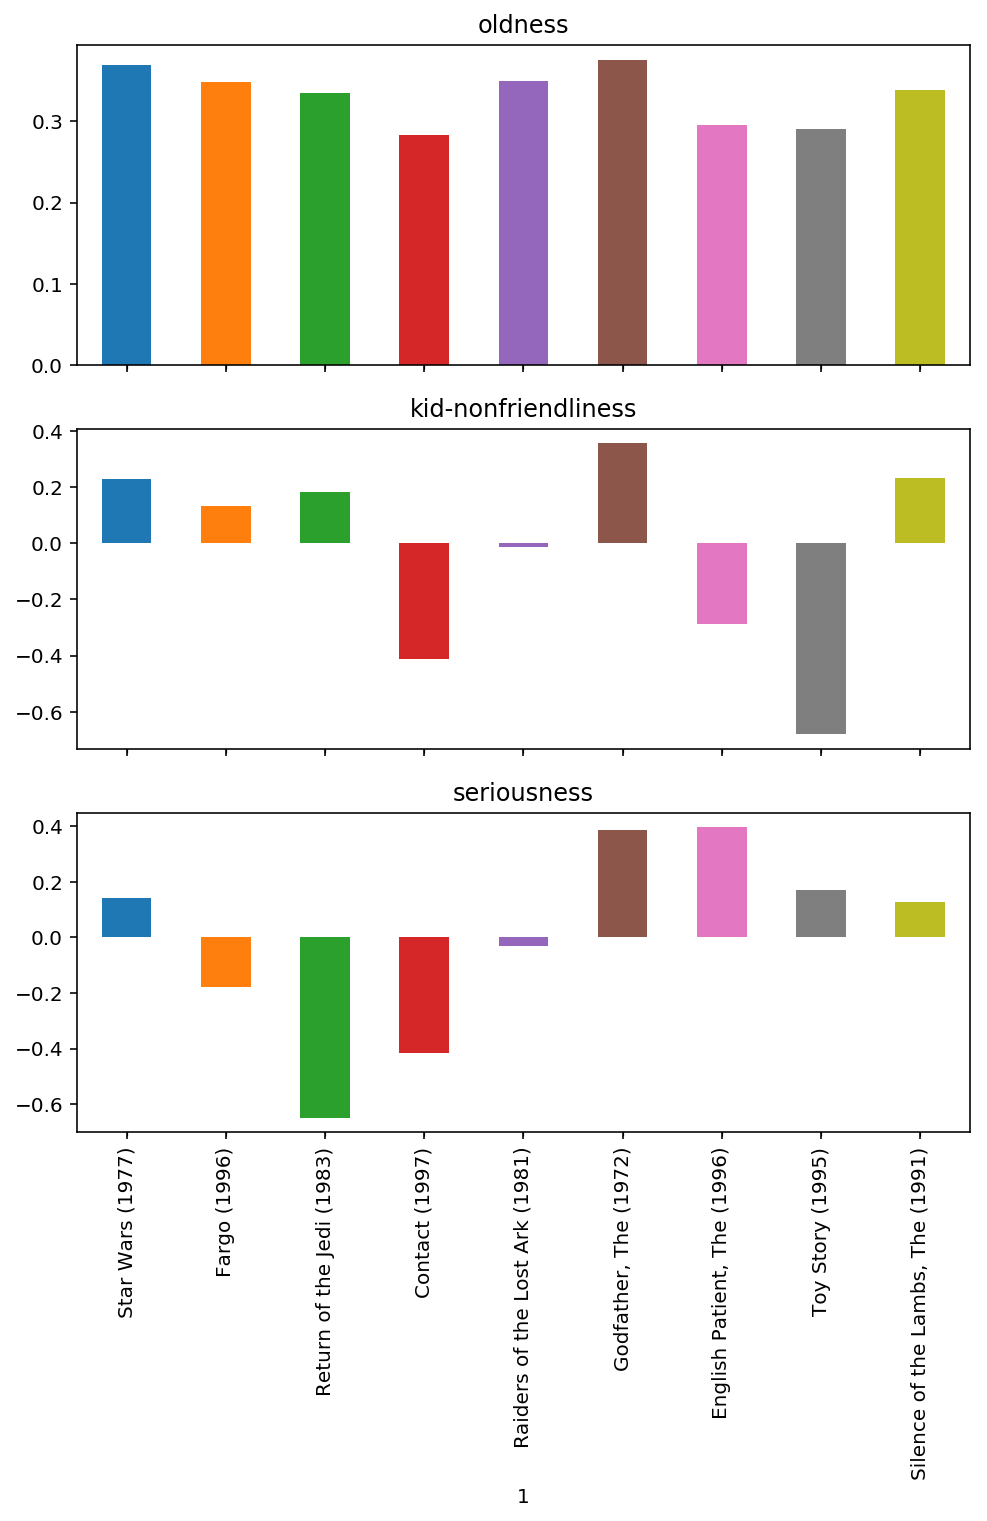

In [27]:
fig, axs = plt.subplots(3, figsize=(8,10), sharex=True)

Q_df[0].plot.bar(ax=axs[0])
axs[0].set_title("oldness")
Q_df[1].plot.bar(ax=axs[1])
axs[1].set_title("kid-nonfriendliness")
Q_df[2].plot.bar(ax=axs[2])
axs[2].set_title("seriousness")

What's happening here: 

* Given a matrix $R$, a mathematical process of uncovers two matrices $P$, $Q$, such that the error function $E(A, PQ^T)$ is minimized.
  * The error function $E$ is usually the sum of squared elementwise differences.
  * If $R$ has shape (m,n), then $P$ has shape (m,p) and $Q$ (n,p).
* For ratings matrices, the factors $P$ and $Q$ can be viewed as the topic profile for users and items respectively. 
  * The row $p_u$ is the topic profile for user $u$, and the row $q_i$ is the topic profile for item $i$.
  * User $u$'s rating of item $i$ is:
  $$r_{u,i} = p_u \cdot q_i$$

## Matrix factorization for recommendation

A proposal to predict a user's rating on an unrated item:

1. Collect all reviews into a utility matrix $R$. This matrix have `nan` values - those are unrated user/item combos.
2. Uncover matrices $P$ and $Q$ to minimize the reconstruction error _on just the reviews present in $R$_.
3. This will yield a stack of user profiles $p_u$ (in the form of $P$), and a stack of item profiles $q_i$ (in the form of $Q$).
4. Our estimate for an absent review $r_{u,i}$ will simply be $p_u \cdot q_i$.

Let's try it!

In [28]:
# if we don't fill in the popular user/movie chunk of our utility matrix
# it already has some hiles
ratings_df = utility.loc[user_ids, movie_ids]
ratings_df

movie_id,50,100,181,258,174,127,286,1,98
user_id,,,,,,,,,
450,5.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0
655,4.0,3.0,3.0,2.0,3.0,5.0,3.0,2.0,4.0
13,5.0,5.0,5.0,4.0,4.0,5.0,3.0,3.0,4.0
416,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
276,5.0,5.0,5.0,5.0,5.0,5.0,NaN,5.0,5.0
303,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0
7,5.0,5.0,3.0,4.0,5.0,5.0,4.0,NaN,4.0
846,5.0,NaN,5.0,3.0,5.0,5.0,NaN,NaN,4.0
59,5.0,5.0,5.0,3.0,5.0,5.0,3.0,2.0,5.0


In [29]:
svd = TruncatedSVD(n_components=3)
svd.fit(ratings_df)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Uh oh!

Easier said than done. In fact, matrix factorization algorithms that gracefully handle missing values are a little exotic. `sklearn` doesn't have one. 

The most accessible implementation is `spark`'s alternative least squares class. We'll explore it in today's assignment.

Another technique is _gradient descent_, which we'll explore for the rest of the lecture.

## Gradient descent for matrix factorization

The basic idea of gradient descent for matrix factorization is:

1. Randomly initialize matrices $P$ and $Q$.

Then do this until convergence:
2. For every non-`nan` rating in matri $R$:
 1. Find the partial derivative of the reconstruction error $f_{u,i}$ of prediction $r_{u,i}$ with respect to the user profile $p_u$ and the item profile $q_i$.
 1. Use the partial derivative to nudge the user and item profiles in the right direction. This is the essence of gradient descent.
 
 

The partial derivatives of the reconstruction loss with respect to the user profile is:

$$\frac{\delta f_{u,i}}{\delta p_u} \propto q_i (r_{u,i} - p_u \cdot q_i)$$

likewise for the item profile:

$$\frac{\delta f_{u,i}}{\delta q_i} \propto p_u (r_{u,i} - p_u \cdot q_i)$$

which you're welcome to verify for yourself with a few minutes and a piece of paper, or follow the derivation here (http://nicolas-hug.com/blog/matrix_facto_3).

Let's do it!




In [30]:
np.random.seed(42)

m, n = ratings_df.shape
p = 3 # three latent dimensions

R = ratings_df.values

In [31]:
#random guesses for P and Q
P = np.random.normal(size=(m,p))
Q = np.random.normal(size=(n,p))

In [32]:
#find reconstructed R
Rhat = P @ Q.T

In [33]:
# our current reconstruction loss
np.nansum( (Rhat - R)**2 )

1768.2352100474013

Let's try our hand at gradient descent.

In [34]:
# we're going to find the gradient for user profile 0 and item profile 0
u, i = 0, 0

In [35]:
reconstruction_error = R[u,i] - P[u].dot(Q[i])

reconstruction_error

5.563722136769471

In [36]:
pu_grad = Q[i]*reconstruction_error
qi_grad = P[u]*reconstruction_error

In [37]:
# direction to push p[u] if we want to decrease error
pu_grad

array([-3.3477284 , 10.30556114, -0.07509481])

In [38]:
# direction to push q[i] if we want to decrese error
qi_grad

array([ 2.76357953, -0.76926415,  3.60355906])

In [39]:
alpha = 0.03 #learning rate

In [40]:
P[u] += alpha*pu_grad
Q[i] += alpha*qi_grad

In [41]:
#find reconstructed R
Rhat = P @ Q.T

In [42]:
# our current reconstruction loss
np.nansum( (Rhat - R)**2 )

1768.585370232403

Bad news, our total reconstruction loss went up a little.

In [43]:
R[u,i] - P[u].dot(Q[i])

4.831911614855228

But the reconstruction error for the rating (0,0) went down a little.

**question** why would the reconstruction error for one item go down, but the whole matrix go up?

### Gradient-descending user/item profiles for ever non-`nan` rating

In [44]:
alpha = 0.03

for u in range(m): # for every user
    for i in range(n): # for every item

        if np.isnan(R[u,i]):         # if this user/item combo hasn't been rated, skip it!
            continue
            
        reconstruction_error = R[u,i] - P[u].dot(Q[i])
        
        # get gradient of error with respect to user profile, item profile
        pu_grad = Q[i]*reconstruction_error
        qi_grad = P[u]*reconstruction_error
        
        # use gradient to push profiles in the right direction
        P[u] += alpha*pu_grad
        Q[i] += alpha*qi_grad

In [45]:
#find reconstructed R
Rhat = P @ Q.T

In [46]:
# our current reconstruction loss
np.nansum( (Rhat - R)**2 )

1117.6734168214814

In [47]:
Rhat

array([[-0.14631399, -0.44561203, -0.25021567, -0.04549427, -0.38101795,
        -0.11559424,  0.10619877, -0.01041285, -0.06123507],
       [-0.28013247, -0.66664687,  1.28180153,  0.46289271,  0.63125707,
        -0.04743762,  1.0227558 ,  0.1915501 ,  1.82165715],
       [ 0.34510411, -0.09115408,  0.76336183,  0.8599015 ,  0.91402267,
        -0.46992686, -0.07489099, -0.46920717,  2.6418512 ],
       [-0.07493571,  0.29586319,  2.20220339,  0.53770782,  1.63400909,
         0.35238995,  1.11613857,  0.39747624,  1.98355273],
       [-0.18181972,  1.69074013,  5.55418874,  0.79843022,  4.22469537,
         1.49805057,  2.72846334,  1.41119586,  3.15568634],
       [-0.48703043,  0.50348677,  2.85767335,  0.0407859 ,  1.74664615,
         1.02427825,  1.94028746,  1.11616789,  0.6879132 ],
       [-0.99851349, -0.46734905,  1.55992288, -0.63061887,  0.15227267,
         0.99193999,  2.06295447,  1.30906226, -1.24763618],
       [ 0.72675627,  2.35771338,  3.09904061,  0.83722766,  3

Recall our original ratings matrix had null values:

In [48]:
R

array([[ 5.,  4.,  4.,  4.,  5.,  5.,  4.,  4.,  4.],
       [ 4.,  3.,  3.,  2.,  3.,  5.,  3.,  2.,  4.],
       [ 5.,  5.,  5.,  4.,  4.,  5.,  3.,  3.,  4.],
       [ 5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.],
       [ 5.,  5.,  5.,  5.,  5.,  5., nan,  5.,  5.],
       [ 5.,  5.,  5.,  4.,  5.,  5.,  5.,  5.,  5.],
       [ 5.,  5.,  3.,  4.,  5.,  5.,  4., nan,  4.],
       [ 5., nan,  5.,  3.,  5.,  5., nan, nan,  4.],
       [ 5.,  5.,  5.,  3.,  5.,  5.,  3.,  2.,  5.],
       [ 4.,  4.,  3.,  2.,  3.,  4.,  3.,  3.,  4.]])

In [49]:
# user 4 had not rated movie 6
R[4, 6]

nan

In [50]:
# but we can estimate what their rating will be,
# simply by taking the dot product of that user profile and that movie profile

P[4].dot(Q[6]) 

2.7284633370627427

User #4 has never rated anything below a 5, so 5 is a good guess.

In [51]:
# user #8 gives mixed reviews, and movie #7 got mixed reviews, so we guess 8 gave 7 a bad review.
P[8].dot(Q[7]) 

0.4201649248889657

### Notes on practice

* Standardize the utility matrix before performing matrix decomposition.
  * We didn't here because it made for a better demo, and the performance can be okay, but better to standardize
* Here we gradient-descended the parameters $P$ and $Q$ to minimize the sum of square errors. It's common to add a regularization term to the loss expression in order to keep the parameters constrained and prevent overfitting.
  * Alternating least squares implementations usually supply a regularization parameter.
* SGD can be constrained to prevent the negative matrix factorizations. Just don't update a parameter past zero!
* SGD is an *excellent* way to estimate ratings for _gigantic_ matrices.
  * It also works well with online learning.

### At scale

If we have time: running SGD for the entire ratings dataset.

Here's the whole thing, `nan`s and all:

In [54]:
utility

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,5.0,NaN,NaN,5.0,5.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
# This algorithm first outlined by Simon Funk. He called it "Funk SVD" because of its superficial
# similarity to the SVD algorithm (i.e., it does matrix decomp). It does not, in fact, find singular values
# and is therefore not an SVD algorithm. Furthermore, the algorithm in use is slightly different than
# Funk's, so calling it "FunkSVD" is wrong on both counts. Alas, the name stuck, so here I'll nod to
# tradition.
class FunkSGD:
    
    def __init__(self, R, n_factors, alpha=0.03):
        # alpha is the learning rate
        
        self.R = R
        self.alpha = alpha
        
        m, n = R.shape
        self.P = np.random.normal(size=(m,n_factors))
        self.Q = np.random.normal(size=(n,n_factors))
        
    def one_iter( self ):
        m, n = self.R.shape
        
        for u in range(m): # for every user
            for i in range(n): # for every item

                if np.isnan(self.R[u,i]):         # if this user/item combo hasn't been rated, skip it!
                    continue

                reconstruction_error = self.R[u,i] - self.P[u].dot(self.Q[i])

                # get gradient of error with respect to user profile, item profile
                pu_grad = self.Q[i]*reconstruction_error
                qi_grad = self.P[u]*reconstruction_error

                # use gradient to push profiles in the right direction
                self.P[u] += alpha*pu_grad
                self.Q[i] += alpha*qi_grad
                
    def reconstruction_loss( self ):
        return np.nansum((self.R - self.P @ self.Q.T)**2)
    

In [72]:
sgd = FunkSGD( utility.values, 10 )

In [73]:
sgd.reconstruction_loss()

2376702.468269878

In [74]:
sgd.one_iter()

In [76]:
sgd.reconstruction_loss()

540044.6633826841

In [129]:
sgd.alpha=0.03

In [212]:
for i in range(100):
    sgd.one_iter()
    print( i+1, sgd.reconstruction_loss() )

1 60695.3711441307
2 60658.42777700805
3 60601.881047659364
4 60542.76154739794
5 60484.079305301944
6 60426.89174832639
7 60371.291537068035
8 60317.26993757375
9 60264.7839473927
10 60213.78179678453
11 60164.2087446223
12 60116.00956066284
13 60069.1296852503
14 60023.515786505865
15 59979.1159720289
16 59935.879804664444
17 59893.75822002474
18 59852.70341223557
19 59812.66873255137
20 59773.60862941884
21 59735.478646272284
22 59698.2354837145
23 59661.83712516562
24 59626.243019223715
25 59591.41430767104
26 59557.314085117454
27 59523.90767454765
28 59491.162902390606
29 59459.05035700942
30 59427.543615584145
31 59396.6194260913
32 59366.25783333805
33 59336.4422406578
34 59307.15940178575
35 59278.39934047365
36 59250.1551984489
37 59222.423015247055
38 59195.20144613032
39 59168.49142664564
40 59142.29579428567
41 59116.618879124224
42 59091.466076161334
43 59066.843412418486
44 59042.75712157219
45 59019.21323814984
46 58996.21722208682
47 58973.773622847104
48 58951.8857904

In [213]:
pd.DataFrame( (sgd.P @ sgd.Q.T).round(1) )

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,3.1,3.2,2.9,3.6,2.5,4.1,4.1,3.6,4.1,3.9,...,0.8,5.1,1.2,-0.3,3.3,3.0,0.7,1.7,1.2,4.4
1,3.7,3.6,1.9,3.4,3.5,5.3,3.5,4.2,3.9,3.2,...,2.6,2.3,2.5,1.9,3.1,1.7,0.8,-2.6,2.6,3.3
2,4.6,3.8,3.1,4.4,3.3,-4.8,4.3,4.9,2.6,3.8,...,5.8,-0.0,4.8,3.1,0.3,-2.8,1.3,-6.3,4.3,3.2
3,3.7,4.4,2.9,3.2,4.4,9.6,4.0,4.3,5.0,4.1,...,1.3,4.8,2.9,2.0,5.4,4.5,-0.4,-0.9,3.9,4.0
4,2.7,3.0,3.6,3.6,2.1,-1.5,4.1,3.1,3.3,4.3,...,2.9,1.8,3.3,0.9,2.3,1.1,-0.1,-1.7,4.0,4.2
5,3.6,2.8,2.1,3.4,2.3,2.3,3.7,4.3,3.9,4.1,...,3.1,1.9,1.9,-1.9,2.9,0.7,1.8,-1.2,4.7,4.1
6,4.8,4.2,2.5,4.0,4.1,0.2,4.5,5.4,4.2,4.6,...,4.5,3.4,3.6,1.4,2.6,0.0,0.4,-3.1,2.6,4.2
7,3.8,3.8,3.4,4.4,3.0,6.7,4.5,4.0,4.5,3.6,...,2.6,3.1,1.6,1.5,4.4,2.3,2.7,0.9,1.4,2.7
8,4.1,4.4,4.0,2.9,4.5,5.1,4.1,4.5,3.9,3.8,...,5.7,0.2,5.6,0.2,2.9,0.8,0.4,-0.5,7.8,0.9
9,4.1,4.3,3.0,4.0,4.0,3.8,4.2,4.5,4.1,3.9,...,3.2,3.2,3.5,3.2,3.5,1.7,0.3,-2.6,2.3,3.7


The ratings for column/movie `1679` are all over the place. Why?

In [214]:
utility.T.iloc[1679].head(20)

user_id
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
19   NaN
20   NaN
Name: 1680, dtype: float64

In [215]:
# it was rated exactly once
utility.T.iloc[1679][ ~utility.T.iloc[1679].isna() ]

user_id
863    2.0
Name: 1680, dtype: float64

Consequently, its movie profile was only ever "nudged" by the SGD algorithm once per iteration. Meanwhile a movie that was rated by all 1000ish users was SGD-nudged about a thousand times.

In [216]:
sgd.Q[ 1679 ]

array([ 1.41295409,  2.09729594,  0.83995278,  0.71103267,  0.94104327,
       -0.40282162,  1.01809006,  0.83321918, -0.30761138, -1.70129823])

This is a cold-start problem - we don't have enough ratings for this movie to give it a genre profile. We could:
* collect more ratings
* give it a default genre profile
* when we predict its ratings, just predict the mean